# Car License Plates De-identification for Privacy Protection  
###: by inpainting license plate

### 0. Introduction

+ **Motivation**

  1.   Proposal of 'Inpainting' as a De-identification Method
    - Existing methods such as mosaic and blur have the *disadvantage of being potentially restorable.*
    - The goal is to create a model where naturally transformed results emerge during the de-identification process.

  2.   Setting the Domain as License Plates
    - While de-identification can be applied across various domains, acquiring datasets for de-identification, especially those containing personal information, can be challenging.
    - Hence, license plates were chosen as the domain for experimentation.

+ **Challenge**
  - Previous Objective: To replace license plates with randomly generated (readable) characters through image segment editing.
  - Model Attempted: InstructPix2Pix
    - Learning to Follow Image Editing Instructions
    - The intention was to use this model to edit existing images.
    - Operation: The model edits images based on user-provided instructions (sentences).
  - Results: The model produced output with characters that were challenging to recognize at once.
    - We have found another alternative
    - The best outcome image:
    ><img src="https://drive.google.com/uc?export=view&id=1GiJrUsSo7ZilxhmG1JYu83-2xMrBeW8u" width="700">
      
      -> Instruction : 'Write random numbers and alphabets on the car plate'
- **Inpainting**  
> Inpainting analyze the available information in the image to estimate and generate the content for the damaged or missing regions

  - Conceived as an Alternative to Generating Fake License Plates
  - Inpainting Utilized for License Plate Removal Using Surrounding Information


- **Datasets**
  -  Kaggle: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
  - Roboflow: https://public.roboflow.com/object-detection/license-plates-us-eu
  - After we put all the data together, we split it into training, validation, and test sets with an 8:1:1 ratio.


###1. Data Preprocessing

####1-1. Splitting the Dataset

In [ ]:
#1-1. Splitting the Dataset

import os
from sklearn.model_selection import train_test_split
import shutil

#. Define a function to split the data
def split_data(input_folder, output_folder, test_size=0.1, val_size=0.1, random_state=42):

    #. Getting a list of image file
    image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]

    #. Splitting the data into Train/Test
    train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=random_state)

    #. Splitting the data into Train/Validation
    train_files, val_files = train_test_split(train_files, test_size=val_size / (1 - test_size), random_state=random_state)

    #. Creating the Train folder
    train_folder = os.path.join(output_folder, "train")
    if not os.path.exists(train_folder):
        os.makedirs(train_folder)

    # Creating the Validation folder
    val_folder = os.path.join(output_folder, "val")
    if not os.path.exists(val_folder):
        os.makedirs(val_folder)

    # Creating the Test folder
    test_folder = os.path.join(output_folder, "test")
    if not os.path.exists(test_folder):
        os.makedirs(test_folder)

    #. Copying the Train data
    for file_name in train_files:
        source_path = os.path.join(input_folder, file_name)
        destination_path = os.path.join(train_folder, file_name)
        shutil.copyfile(source_path, destination_path)

    # Copying the Validation data
    for file_name in val_files:
        source_path = os.path.join(input_folder, file_name)
        destination_path = os.path.join(val_folder, file_name)
        shutil.copyfile(source_path, destination_path)

    # Copying the Test data
    for file_name in test_files:
        source_path = os.path.join(input_folder, file_name)
        destination_path = os.path.join(test_folder, file_name)
        shutil.copyfile(source_path, destination_path)

#. Specifying the input and output folders
input_folder_path = './dataset/all' #. Path to the folder where two datasets are merged
output_folder_path = './dataset/splitted_data' #. Path to the 'splitted_data' folder with train/val/test images

# Function 'split_data' call (test_size, val_size, and random_state can be adjusted as needed)
split_data(input_folder_path, output_folder_path, test_size=0.1, val_size=0.1, random_state=42)

####1-2. Dataset Preprocessing

- Loaded and preprocessed the dataset through the **'Dataset'** class
- After preprocessing, loaded the data using DataLoader
    - Dataset: Stores samples and their corresponding labels
    - DataLoader: Wraps the Dataset, making it iterable for easy access to samples
- Read the comments below to understand the part where the data is loaded
- Partial code from data/dataset.py, uses this class to load the dataset.

```
class Dataset(data.Dataset):
    def __init__(self, data_path, image_shape, with_subfolder=False, random_crop=True, return_name=False):
        super(Dataset, self).__init__()
        if with_subfolder:
            self.samples = self._find_samples_in_subfolders(data_path)
        else:
            self.samples = [x for x in listdir(data_path) if is_image_file(x)]
        self.data_path = data_path
        self.image_shape = image_shape[:-1]
        self.random_crop = random_crop
        self.return_name = return_name

    def __getitem__(self, index):
        path = os.path.join(self.data_path, self.samples[index])
        # path = os.path.join(self.data_path)
        img = default_loader(path)

        if self.random_crop:
            imgw, imgh = img.size
            if imgh < self.image_shape[0] or imgw < self.image_shape[1]:
                img = transforms.Resize(min(self.image_shape))(img)
            img = transforms.RandomCrop(self.image_shape)(img)
        else:
            img = transforms.Resize(self.image_shape)(img)
            img = transforms.RandomCrop(self.image_shape)(img)

        img = transforms.ToTensor()(img)  # turn the image to a tensor
        img = normalize(img)

        if self.return_name:
            return self.samples[index], img
        else:
            return img
```

### 2. Validation

- **Evaluation Measures**
  - GAN models typically employ 'Inception Score' or 'SSIM' for evaluation.
    - Both measure how well the generated images reconstruct the original content.
  - However, these metrics are not suitable for our model.
    - This is because our model's primary objective is not faithful restoration of the original content.
  - Metrics Chosen for Our Model: **Total Variation Loss(TV Loss)**
    - Reference the paper(https://arxiv.org/abs/1801.07892)

  

-  TV Loss(Total Variation Loss)
    - It calculates the variation (changes) between adjacent pixels along the vertical and horizontal axes of a single image and sums them up.
    - A high TV loss indicates that the image is spatially smooth with minimal noise.
    ><img src="https://drive.google.com/uc?export=view&id=1e-0uWwPfQdka-An5hCrtIRBF73q_L-C3" width="500">


In [ ]:
# Import required libraries, etc
import os
import random
import time
import shutil
from argparse import ArgumentParser

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
from tensorboardX import SummaryWriter

from trainer import Trainer
import torchvision.transforms as transforms

from data.dataset import Dataset
from utils.tools import get_config, random_bbox, mask_image, is_image_file, default_loader, get_model_list, normalize
from utils.logger import get_logger
from model.networks import Generator
import torch.nn.functional as F
import matplotlib.pyplot as plt
import csv

torch.autograd.set_detect_anomaly(True)

parser = ArgumentParser()
parser.add_argument('--config', type=str, default='configs/config.yaml',
                    help="training configuration")
parser.add_argument('--seed', type=int, help='manual seed')


_StoreAction(option_strings=['--seed'], dest='seed', nargs=None, const=None, default=None, type=<class 'int'>, choices=None, required=False, help='manual seed', metavar=None)

In [ ]:
# Validation

# Calculate performance metric of validation dataset.
def validate(trainer, val_loader, config, iteration, writer, device):
    trainer.eval() # Model Evaluation Mode
    total_loss_d = 0.0 # .Variable to store the loss of the Discriminator
    total_loss_g = 0.0 # .Loss of Generator
    # Utilizing the above two losses for selecting the iteration with the narrowest gap between each loss

    # .Evaluation Metrics: TV loss
    total_loss_tv = 0.0

    iterable_val_loader = iter(val_loader) #. Load the data loader
    trainer_module = trainer.module
    start_iteration = trainer_module.resume(config['resume']) if config['resume'] else 1

    try:
        ground_truth = next(iterable_val_loader) # ground_truth : Original images
    except StopIteration:
        iterable_val_loader = iter(val_loader)
        ground_truth = next(iterable_val_loader)

    # Prepare the inputs
    """
    random_bbox : Generate a random tlhw with configuration.

    Args:
        config: Config should have configuration including img

    Returns:
        tuple: (top, left, height, width)

    """

    bboxes = random_bbox(config, batch_size=ground_truth.size(0))

    # x : Masked images, mask : The mask itself (white and black rectangle)
    x, mask = mask_image(ground_truth, bboxes, config)

    if device:
        x = x.cuda()
        mask = mask.cuda()
        ground_truth = ground_truth.cuda()


    # Perform inference
    #. losses : losses, inpainted_result : Generated images (output)
    losses, inpainted_result, _ = trainer(x, bboxes, mask, ground_truth)

    # Average of losses
    for k in losses.keys():
        if not losses[k].dim() == 0:
            losses[k] = torch.mean(losses[k])

    # Discriminator loss
    losses['d'] = losses['wgan_d'] + losses['wgan_gp'] * config['wgan_gp_lambda']
    # Generator loss
    losses['g'] = losses['l1'] * config['l1_loss_alpha'] \
            + losses['ae'] * config['ae_loss_alpha'] \
            + losses['wgan_g'] * config['gan_loss_alpha']

    # Calculate TV loss : Obtained through the generated images
    tv_loss = torch.sum(torch.abs(inpainted_result[:, :, :, :-1] - inpainted_result[:, :, :, 1:])) + \

    # Accumulate the validation loss
    total_loss_d += losses['d'].item()
    total_loss_g += losses['g'].item()  # Add this line
    total_loss_tv += tv_loss.item()  # Add this line


    # Calculate average validation loss
    avg_loss_d = total_loss_d / len(val_loader)
    avg_loss_g = total_loss_g / len(val_loader)  # Add this line
    avg_loss_tv = total_loss_tv / len(val_loader)

    # Print or log the average validation loss
    print(f'Average Validation Loss (Discriminator): {avg_loss_d}')
    print(f'Average Validation Loss (Generator): {avg_loss_g}')  # Add this line
    print(f'Average Validation Loss (TV): {avg_loss_tv}')

    writer.add_scalar('val_loss_d', avg_loss_d, iteration)
    writer.add_scalar('val_loss_g', avg_loss_g, iteration)  # Add this line

    return avg_loss_tv, avg_loss_d, avg_loss_g



### 3. Training

- Trainer Class Used for Model Training
  - We referred to the paper for architecture composition (https://arxiv.org/abs/1801.07892)

````
import os
import torch
import torch.nn as nn
from torch import autograd
from model.networks import Generator, LocalDis, GlobalDis


from utils.tools import get_model_list, local_patch, spatial_discounting_mask
from utils.logger import get_logger

logger = get_logger()


class Trainer(nn.Module):
    def __init__(self, config):
        super(Trainer, self).__init__()
        self.config = config
        self.use_cuda = self.config['cuda']
        self.device_ids = self.config['gpu_ids']

        self.netG = Generator(self.config['netG'], self.use_cuda, self.device_ids)
        self.localD = LocalDis(self.config['netD'], self.use_cuda, self.device_ids)
        self.globalD = GlobalDis(self.config['netD'], self.use_cuda, self.device_ids)

        self.optimizer_g = torch.optim.Adam(self.netG.parameters(), lr=self.config['lr'],
                                            betas=(self.config['beta1'], self.config['beta2']))
        d_params = list(self.localD.parameters()) + list(self.globalD.parameters())
        self.optimizer_d = torch.optim.Adam(d_params, lr=config['lr'],
                                            betas=(self.config['beta1'], self.config['beta2']))
        if self.use_cuda:
            self.netG.to(self.device_ids[0])
            self.localD.to(self.device_ids[0])
            self.globalD.to(self.device_ids[0])

    def forward(self, x, bboxes, masks, ground_truth, compute_loss_g=False):
        self.train()
        l1_loss = nn.L1Loss()
        losses = {}

        x1, x2, offset_flow = self.netG(x, masks)
        local_patch_gt = local_patch(ground_truth, bboxes)
        x1_inpaint = x1 * masks + x * (1. - masks)
        x2_inpaint = x2 * masks + x * (1. - masks)
        local_patch_x1_inpaint = local_patch(x1_inpaint, bboxes)
        local_patch_x2_inpaint = local_patch(x2_inpaint, bboxes)

        # D part
        # wgan d loss
        local_patch_real_pred, local_patch_fake_pred = self.dis_forward(
            self.localD, local_patch_gt, local_patch_x2_inpaint.detach())
        global_real_pred, global_fake_pred = self.dis_forward(
            self.globalD, ground_truth, x2_inpaint.detach())
        losses['wgan_d'] = torch.mean(local_patch_fake_pred - local_patch_real_pred) + \
            torch.mean(global_fake_pred - global_real_pred) * self.config['global_wgan_loss_alpha']
        # gradients penalty loss
        local_penalty = self.calc_gradient_penalty(
            self.localD, local_patch_gt, local_patch_x2_inpaint.detach())
        global_penalty = self.calc_gradient_penalty(self.globalD, ground_truth, x2_inpaint.detach())
        losses['wgan_gp'] = local_penalty + global_penalty

        # G part
        if compute_loss_g:
            sd_mask = spatial_discounting_mask(self.config)
            losses['l1'] = l1_loss(local_patch_x1_inpaint * sd_mask, local_patch_gt * sd_mask) * \
                self.config['coarse_l1_alpha'] + \
                l1_loss(local_patch_x2_inpaint * sd_mask, local_patch_gt * sd_mask)
            losses['ae'] = l1_loss(x1 * (1. - masks), ground_truth * (1. - masks)) * \
                self.config['coarse_l1_alpha'] + \
                l1_loss(x2 * (1. - masks), ground_truth * (1. - masks))

            # wgan g loss
            local_patch_real_pred, local_patch_fake_pred = self.dis_forward(
                self.localD, local_patch_gt, local_patch_x2_inpaint)
            global_real_pred, global_fake_pred = self.dis_forward(
                self.globalD, ground_truth, x2_inpaint)
            losses['wgan_g'] = - torch.mean(local_patch_fake_pred) - \
                torch.mean(global_fake_pred) * self.config['global_wgan_loss_alpha']

        return losses, x2_inpaint, offset_flow
    
    def dis_forward(self, netD, ground_truth, x_inpaint):
        assert ground_truth.size() == x_inpaint.size()
        batch_size = ground_truth.size(0)
        batch_data = torch.cat([ground_truth, x_inpaint], dim=0)
        batch_output = netD(batch_data)
        real_pred, fake_pred = torch.split(batch_output, batch_size, dim=0)

        return real_pred, fake_pred
   
    # Calculate gradient penalty
    def calc_gradient_penalty(self, netD, real_data, fake_data):
        batch_size = real_data.size(0)
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()

        interpolates = alpha * real_data + (1 - alpha) * fake_data
        interpolates = interpolates.requires_grad_().clone()

        disc_interpolates = netD(interpolates)
        grad_outputs = torch.ones(disc_interpolates.size())

        if self.use_cuda:
            grad_outputs = grad_outputs.cuda()

        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=grad_outputs, create_graph=True,
                                  retain_graph=True, only_inputs=True)[0]

        gradients = gradients.view(batch_size, -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

        return gradient_penalty

    def inference(self, x, masks):
        self.eval()
        x1, x2, offset_flow = self.netG(x, masks)
        # x1_inpaint = x1 * masks + x * (1. - masks)
        x2_inpaint = x2 * masks + x * (1. - masks)

        return x2_inpaint, offset_flow

    def save_model(self, checkpoint_dir, iteration):
        # Save generators, discriminators, and optimizers
        gen_name = os.path.join(checkpoint_dir, 'gen_%08d.pt' % iteration)
        dis_name = os.path.join(checkpoint_dir, 'dis_%08d.pt' % iteration)
        opt_name = os.path.join(checkpoint_dir, 'optimizer.pt')
        torch.save(self.netG.state_dict(), gen_name)
        torch.save({'localD': self.localD.state_dict(),
                    'globalD': self.globalD.state_dict()}, dis_name)
        torch.save({'gen': self.optimizer_g.state_dict(),
                    'dis': self.optimizer_d.state_dict()}, opt_name)

    def resume(self, checkpoint_dir, iteration=0, test=False):
        # Load generators
        last_model_name = get_model_list(checkpoint_dir, "gen", iteration=iteration)
        self.netG.load_state_dict(torch.load(last_model_name))
        iteration = int(last_model_name[-11:-3])

        if not test:
            # Load discriminators
            last_model_name = get_model_list(checkpoint_dir, "dis", iteration=iteration)
            state_dict = torch.load(last_model_name)
            self.localD.load_state_dict(state_dict['localD'])
            self.globalD.load_state_dict(state_dict['globalD'])
            # Load optimizers
            state_dict = torch.load(os.path.join(checkpoint_dir, 'optimizer.pt'))
            self.optimizer_d.load_state_dict(state_dict['dis'])
            self.optimizer_g.load_state_dict(state_dict['gen'])

        print("Resume from {} at iteration {}".format(checkpoint_dir, iteration))
        logger.info("Resume from {} at iteration {}".format(checkpoint_dir, iteration))

        return iteration
````

- Training

In [ ]:
# Starting the Main Function
def main():
    args = parser.parse_args()
    config = get_config(args.config)

    # Store values into lists for visualization
    avg_loss_tv_list = []
    avg_loss_g_list = []
    avg_loss_d_list = []

    # CUDA configuration
    cuda = config['cuda']
    device_ids = config['gpu_ids']
    if cuda:
        os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(i) for i in device_ids)
        device_ids = list(range(len(device_ids)))
        config['gpu_ids'] = device_ids
        cudnn.benchmark = True

    # Configure checkpoint path
    # checkpoint : The weight of the trained model

    # # Checkpoint saved location, saved every specified interval (1000)
    checkpoint_path = os.path.join('checkpoints',
                                config['dataset_name'],
                                config['mask_type'] + '_' + config['expname'])

    # If the checkpoint path does not exist, create the directory
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    shutil.copy(args.config, os.path.join(checkpoint_path, os.path.basename(args.config)))
    writer = SummaryWriter(logdir=checkpoint_path)
    logger = get_logger(checkpoint_path)    # get logger and configure it at the first call

    logger.info("Arguments: {}".format(args))

    # Set random seed
    if args.seed is None:
        args.seed = random.randint(1, 10000)
    logger.info("Random seed: {}".format(args.seed))
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    if cuda:
        torch.cuda.manual_seed_all(args.seed)

    # Log the configuration
    logger.info("Configuration: {}".format(config))


    #. Load Dataset ! loader

    try:  # for unexpected error logging
        # Load the dataset
        logger.info("Training on dataset: {}".format(config['dataset_name']))
        train_dataset = Dataset(data_path=config['train_data_path'],
                                with_subfolder=config['data_with_subfolder'], #False
                                image_shape=config['image_shape'], # The input size must always be 256*256
                                random_crop=config['random_crop']) # During training, randomly crop 256*256 at random positions
        val_dataset = Dataset(data_path=config['val_data_path'],
                            with_subfolder=config['data_with_subfolder'],
                                image_shape=config['image_shape'],
                            random_crop=config['random_crop'])
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=config['batch_size'],
                                                shuffle=True,
                                                num_workers=config['num_workers'])
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                batch_size=config['batch_size'],
                                                shuffle=False,
                                                num_workers=config['num_workers'])

        # Define the trainer
        trainer = Trainer(config)
        logger.info("\n{}".format(trainer.netG))
        logger.info("\n{}".format(trainer.localD))
        logger.info("\n{}".format(trainer.globalD))

        if cuda:
            trainer = nn.parallel.DataParallel(trainer, device_ids=device_ids)
            trainer_module = trainer.module
        else:
            trainer_module = trainer

        # Get the resume iteration to restart training
        start_iteration = trainer_module.resume(config['resume']) if config['resume'] else 1

        iterable_train_loader = iter(train_loader)

        time_count = time.time()


        # Start Iteration(niter is 100 thousand)
        for iteration in range(start_iteration, config['niter'] + 1):

            try:
                ground_truth = next(iterable_train_loader)
            except StopIteration:
                iterable_train_loader = iter(train_loader)
                ground_truth = next(iterable_train_loader)

            # Prepare the inputs
            bboxes = random_bbox(config, batch_size=ground_truth.size(0))
            x, mask = mask_image(ground_truth, bboxes, config)
            if cuda:
                x = x.cuda()
                mask = mask.cuda()
                ground_truth = ground_truth.cuda()

            ###### Forward pass ######
            compute_g_loss = iteration % config['n_critic'] == 0
            losses, inpainted_result, offset_flow = trainer(x, bboxes, mask, ground_truth, compute_g_loss)
            # Scalars from different devices are gathered into vectors
            for k in losses.keys():
                if not losses[k].dim() == 0:
                    losses[k] = torch.mean(losses[k])

            ###### Backward pass ###### Backpropagation and weight update after Discriminator
            # Update D
            trainer_module.optimizer_d.zero_grad()
            losses['d'] = losses['wgan_d'] + losses['wgan_gp'] * config['wgan_gp_lambda']
            losses['d'].backward()
            # trainer_module.optimizer_d.step()

            ###### Update G Generator ###### Backpropagation and weight update after Generator
            if compute_g_loss:
                trainer_module.optimizer_g.zero_grad()
                losses['g'] = losses['l1'] * config['l1_loss_alpha'] \
                            + losses['ae'] * config['ae_loss_alpha'] \
                            + losses['wgan_g'] * config['gan_loss_alpha']
                losses['g'].backward()


                trainer_module.optimizer_d.step()
                trainer_module.optimizer_g.step()

            # Log and visualization
            log_losses = ['l1', 'ae', 'wgan_g', 'wgan_d', 'wgan_gp', 'g', 'd']
            if iteration % config['print_iter'] == 0:
                time_count = time.time() - time_count
                speed = config['print_iter'] / time_count
                speed_msg = 'speed: %.2f batches/s ' % speed
                time_count = time.time()

                message = 'Iter: [%d/%d] ' % (iteration, config['niter'])
                for k in log_losses:
                    v = losses.get(k, 0.)
                    writer.add_scalar(k, v, iteration)
                    message += '%s: %.6f ' % (k, v)
                message += speed_msg
                logger.info(message)

            # Save inpainted results (images) to the Checkpoint path along with the checkpoint at the intervals specified in the config
            if iteration % (config['viz_iter']) == 0:
                viz_max_out = config['viz_max_out']
                if x.size(0) > viz_max_out:
                    viz_images = torch.stack([x[:viz_max_out], inpainted_result[:viz_max_out],
                                            offset_flow[:viz_max_out]], dim=1)
                else:
                    viz_images = torch.stack([x, inpainted_result, offset_flow], dim=1)
                viz_images = viz_images.view(-1, *list(x.size())[1:])
                vutils.save_image(viz_images,
                                '%s/niter_%03d.png' % (checkpoint_path, iteration),
                                nrow=3 * 4,
                                normalize=True)

            # For validation visualization
            avg_loss_tv, avg_loss_d, avg_loss_g = validate(trainer, val_loader, config, iteration, writer, device=torch.device('cuda' if cuda else 'cpu'))
            avg_loss_tv_list.append(avg_loss_tv)  # append the value for visualization
            avg_loss_d_list.append(avg_loss_d)
            avg_loss_g_list.append(avg_loss_g)

            # Save the model per 1000,
            if iteration % config['snapshot_save_iter'] == 0:
                trainer_module.save_model(checkpoint_path, iteration)

        # Save avg_loss_tv_list as a CSV file
        csv_file_path = ('./result/avg_loss_tv_list.csv')
        with open(csv_file_path, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Avg Loss TV'])
            for i, avg_loss_tv in enumerate(avg_loss_tv_list):
                csv_writer.writerow([avg_loss_tv])

        # Save avg_loss_g_list as a CSV file
        csv_file_path = ('./result/avg_loss_g_list.csv')
        with open(csv_file_path, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Avg Loss G'])
            for i, avg_loss_g in enumerate(avg_loss_g_list):
                csv_writer.writerow([avg_loss_g])

        # Save avg_loss_d_list as a CSV file
        csv_file_path = ('./result/avg_loss_d_list.csv')
        with open(csv_file_path, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(['Avg Loss D'])
            for i, avg_loss_d in enumerate(avg_loss_d_list):
                csv_writer.writerow([avg_loss_d])

        # Visualization of avg_loss_g and avg_loss_d after training
        plt.plot(avg_loss_g_list, label='avg_loss_g')
        plt.plot(avg_loss_d_list, label='avg_loss_d')
        plt.title('Average Generator and Discriminator Loss of Validation Set')
        plt.xlabel('Iteration')
        plt.ylabel('Average Loss')
        plt.legend()

        # Save the plot as an image
        plt.savefig('./result/train_g_d_loss_plt')

        # Close the plot
        plt.close()



    except Exception as e:  # for unexpected error logging
        logger.error("{}".format(e))
        raise e

if __name__ == '__main__':
    main()


- Performance measure using test data

In [ ]:
# Performance test code

import os
from argparse import ArgumentParser
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from utils.tools import get_config
from data.dataset import Dataset
from model.networks import Generator
from trainer import Trainer
from utils.tools import get_config, random_bbox, mask_image


parser = ArgumentParser()
parser.add_argument('--config', type=str, default='configs/config.yaml', help="training configuration")
parser.add_argument('--seed', type=int, help='manual seed')
parser.add_argument('--checkpoint_path', type=str, default='')
parser.add_argument('--iter', type=int, default=0)


def validate_test(trainer, test_loader, config, iteration, writer, device):
    # Implement the validation logic for the test_loader
    # You can refer to the existing validate function and modify it as needed
    trainer.eval()
    total_loss_d = 0.0
    total_loss_g = 0.0  # Add this line
    total_loss_tv = 0.0

    iterable_val_loader = iter(test_loader)
    trainer_module = trainer.module
    start_iteration = trainer_module.resume(config['resume']) if config['resume'] else 1

    try:
        ground_truth = next(iterable_val_loader)
    except StopIteration:
        iterable_val_loader = iter(test_loader)
        ground_truth = next(iterable_val_loader)

    # Prepare the inputs
    bboxes = random_bbox(config, batch_size=ground_truth.size(0))
    x, mask = mask_image(ground_truth, bboxes, config)
    if device:
        x = x.cuda()
        mask = mask.cuda()
        ground_truth = ground_truth.cuda()

    bboxes = random_bbox(config, batch_size=x.size(0))

        # Inference
    x1, x2, offset_flow = trainer(ground_truth, mask)
    inpainted_result = x2 * mask + ground_truth * (1. - mask)

    # Calculate TV loss
    tv_loss = torch.sum(torch.abs(inpainted_result[:, :, :, :-1] - inpainted_result[:, :, :, 1:])) + \
            torch.sum(torch.abs(inpainted_result[:, :, :-1, :] - inpainted_result[:, :, 1:, :]))


    return avg_loss_tv


def main():
    args = parser.parse_args()
    config = get_config(args.config)

    # CUDA configuration
    cuda = config['cuda']
    device_ids = config['gpu_ids']
    if cuda:
        os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(i) for i in device_ids)
        device_ids = list(range(len(device_ids)))
        config['gpu_ids'] = device_ids

    print("Arguments: {}".format(args))

    # Set random seed
    if args.seed is None:
        args.seed = torch.randint(1, 10000, (1,)).item()
    print("Random seed: {}".format(args.seed))
    torch.manual_seed(args.seed)
    if cuda:
        torch.cuda.manual_seed_all(args.seed)

    print("Configuration: {}".format(config))

    try:
        with torch.no_grad():

            # Define the generator
            netG = Generator(config['netG'], cuda, device_ids)

            # Load the model checkpoint
            checkpoint_file = os.path.join(args.checkpoint_path, f'gen_00060000.pt')
            if os.path.exists(checkpoint_file):
                netG.load_state_dict(torch.load(checkpoint_file))
            else:
                raise FileNotFoundError(f"Checkpoint file '{checkpoint_file}' does not exist.")

            if cuda:
                netG = nn.parallel.DataParallel(netG, device_ids=device_ids)

            # Load the test dataset
            test_dataset = Dataset(data_path=config['test_data_path'],
                                   with_subfolder=config['data_with_subfolder'],
                                   image_shape=config['image_shape'],
                                   random_crop=config['random_crop'])
            test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                      batch_size=config['batch_size'],
                                                      shuffle=False,
                                                      num_workers=config['num_workers'])

            # Create SummaryWriter for tensorboard logging
            writer = SummaryWriter(logdir=args.checkpoint_path)

            # Perform test/validation
            validate_test(netG, test_loader, config, args.iter, writer, device=torch.device('cuda' if cuda else 'cpu'))

    except Exception as e:
        print("Error: {}".format(e))
        raise e

if __name__ == '__main__':
    main()


- **Model Performance on Test Data**

  - tv loss : 22048.00625 -(regularization)--> **about 43.5516 %**
  - In the paper, TV loss was 25.3%. That's a relatively good number.
  - **The most desirable n-iter is 60000.**

- train_g_d_loss_plt:
  ><img src="https://drive.google.com/uc?export=view&id=1bwPAkD6Gd4EaKmA_30pz8-9tzcgsWVWG" width="400">
- train_tv_loss_plt:
   ><img src="https://drive.google.com/uc?export=view&id=1cdfnR-9YPO-yNbaYuVOOwn0KAj9-xxrF" width="400">



In [ ]:
# %pip install tensorboardX

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd
%cd drive
%cd MyDrive
%cd generative-inpainting-pytorch

!nvidia-smi

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/generative-inpainting-pytorch
Tue Dec 12 15:42:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+---------------------

In [ ]:
# Inference Single Image (colab demo)

import os
import random
from argparse import ArgumentParser

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.utils as vutils

from model.networks import Generator
from utils.tools import get_config, is_image_file, default_loader, normalize, get_model_list

parser = ArgumentParser()
# parser.add_argument('--config', type=str, default='configs/config.yaml', help="training configuration")
# parser.add_argument('--seed', type=int, help='manual seed')
# parser.add_argument('--image', type=str, default='./examples/test_img.png')
# parser.add_argument('--output', type=str, default='./examples/output.png')
# parser.add_argument('--checkpoint_path', type=str, default='')
# parser.add_argument('--iter', type=int, default=0)
# parser.add_argument('--x1', type=int, help='Top-left x-coordinate of the rectangular region', default=72)
# parser.add_argument('--y1', type=int, help='Top-left y-coordinate of the rectangular region', default=114)
# parser.add_argument('--x2', type=int, help='Bottom-right x-coordinate of the rectangular region', default=184)
# parser.add_argument('--y2', type=int, help='Bottom-right y-coordinate of the rectangular region', default=142)



# Define the bbox2mask function for 'customised bbox' according to coordinates (important!!)
# bbox2mask: Inpaints the specified region of the image corresponding to the license plate.
def bbox2mask(bbox, h, w):
    mask = torch.zeros((1, h, w), dtype=torch.float32)
    y1, x1, y2, x2 = bbox
    y1 = y1
    x1 = x1
    y2 = y2
    x2 = x2
    mask[:, y1:y2, x1:x2] = 1.0
    return mask


def main():
    config_path = 'configs/config.yaml'
    # args = parser.parse_args()
    config = get_config(config_path)


    # CUDA configuration
    cuda = config['cuda']
    device_ids = config['gpu_ids']
    if cuda:
        os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(i) for i in device_ids)
        device_ids = list(range(len(device_ids)))
        config['gpu_ids'] = device_ids
        cudnn.benchmark = True

    # print("Arguments: {}".format(args))

    seed = None
    # Set random seed
    if seed is None:
        seed = random.randint(1, 10000)
    print("Random seed: {}".format(seed))
    random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

    print("Configuration: {}".format(config))

    try:
        with torch.no_grad():
            if is_image_file('./examples/test_img.png'):
                # Test a single ground-truth image with a mask at the specified rectangular region
                ground_truth = default_loader('./examples/test_img.png')
                ground_truth = transforms.ToTensor()(ground_truth)
                ground_truth = normalize(ground_truth)
                ground_truth = ground_truth.unsqueeze(dim=0)

                # Create a mask for the specified rectangular region
                mask = bbox2mask((114, 72, 142, 184),
                                config['image_shape'][1], config['image_shape'][0])
                mask = mask.unsqueeze(dim=0)

                # Set checkpoint path
                checkpoint_path = os.path.join('checkpoints', config['dataset_name'],
                                config['mask_type'] + '_' + config['expname'])

                # Define the trainer
                netG = Generator(config['netG'], cuda, device_ids)
                # Checkpoint model
                model_name = './checkpoints/imagenet/hole/gen_00060000.pt'
                netG.load_state_dict(torch.load(model_name))
                model_iteration = 0
                print("Resume from {} at iteration {}".format(checkpoint_path, model_iteration))

                if cuda:
                    netG = nn.parallel.DataParallel(netG, device_ids=device_ids)
                    ground_truth = ground_truth.cuda()
                    mask = mask.cuda()

                # Inference
                x1, x2, offset_flow = netG(ground_truth, mask)
                inpainted_result = x2 * mask + ground_truth * (1. - mask)

                vutils.save_image(inpainted_result, './examples/output.png', padding=0, normalize=True)
                print("Saved the inpainted result to {}".format('./examples/output.png'))
            else:
                raise TypeError("{} is not an image file.".format('./examples/test_img.png'))
    except Exception as e:
        print("Error: {}".format(e))
        raise e

if __name__ == '__main__':
    main()


Random seed: 8318
Configuration: {'dataset_name': 'imagenet', 'data_with_subfolder': False, 'train_data_path': './dataset/train', 'val_data_path': './dataset/val', 'resume': None, 'batch_size': 8, 'image_shape': [256, 256, 3], 'mask_shape': [128, 128], 'mask_batch_same': True, 'max_delta_shape': [32, 32], 'margin': [0, 0], 'discounted_mask': True, 'spatial_discounting_gamma': 0.9, 'random_crop': True, 'mask_type': 'hole', 'mosaic_unit_size': 12, 'expname': 'benchmark', 'cuda': True, 'gpu_ids': [0], 'num_workers': 4, 'lr': 0.0001, 'beta1': 0.5, 'beta2': 0.9, 'n_critic': 5, 'niter': 100000, 'print_iter': 100, 'val_print_iter': 1000, 'viz_iter': 1000, 'viz_max_out': 16, 'snapshot_save_iter': 1000, 'coarse_l1_alpha': 1.2, 'l1_loss_alpha': 1.2, 'ae_loss_alpha': 1.2, 'global_wgan_loss_alpha': 1.0, 'gan_loss_alpha': 0.001, 'wgan_gp_lambda': 10, 'netG': {'input_dim': 3, 'ngf': 32}, 'netD': {'input_dim': 3, 'ndf': 64}}
Resume from checkpoints/imagenet/hole_benchmark at iteration 0
Saved the inp

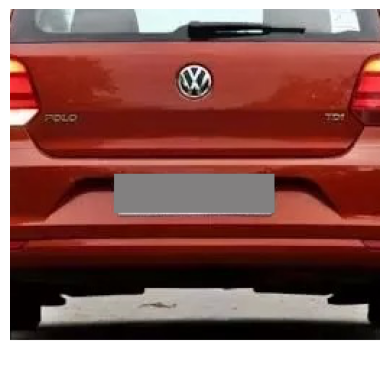

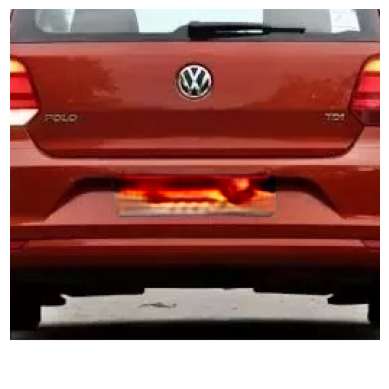

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def visualize_image(image_path):
    # Open img
    img = Image.open(image_path)

    # Image Visualization
    plt.imshow(img)
    plt.axis('off')  # 축 제거
    plt.show()

# Specify the image file path
input_path = './examples/test_img.png'
output_path = './examples/output.png'

# Image Visualization
visualize_image(input_path)
visualize_image(output_path)

### 4. Service

- When an image containing a car license plate is uploaded, the service ...
  - detects the license plate
  - infers the detected license plate using our model and return the image with the license plate removed

- **Why the Service is Needed:**
  - The size of images containing license plates is not always fixed.
    - Our current inpainting model only processes input images of a fixed size (256*256).
  - To make it easier for users to integrate our model, the service automates the resizing of images within the application.

- **Models Applied in the Service:**
  1. License Plate Detection Model (pre-trained): Locates the position of the license plate.
  2. Our custom generation model: Performs inpainting on the detected license plate region.

- **Procedure of service**
1. Original Image
><img src="https://drive.google.com/uc?export=view&id=187EfYTcVo_MoILTYIO_7coyuxG9Xh6UN" width="400">


2. Image with Detected License Plate
><img src="https://drive.google.com/uc?export=view&id=1yKDcQ5fXPslhKzK41tsdQJncJuRUAOE2" width="400">

3. Image with Masked License Plate
><img src="https://drive.google.com/uc?export=view&id=1fubeU0SC6IFwtuEUijLAu1Y6AtBrABNZ" width="400">


4. Resized Image around the License Plate (256*256)
- If it goes over the border, I gave the padding in white.
><img src="https://drive.google.com/uc?export=view&id=15o7Fr8sLzyg-sGr8428ia8sihagOsgyL" width="400">


5. Generated Image in the License Plate Region
><img src="https://drive.google.com/uc?export=view&id=1v4erbus5rw7YPpznVqqu-_VzcdHJ96IM" width="400">


6. Output Image
><img src="https://drive.google.com/uc?export=view&id=1zeZYbjFMRhdM1d9QNIdZLZYQNRCz_gfi" width="400">


- **Service Demo Video Link:** https://youtu.be/-QsQk19iwlw?si=Y6783NvEu21TOiTA
- **Github link:** https://github.com/jeewonkimm2/generative-inpainting-pytorch/tree/jeewon